In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class LIDCDataset(Dataset):

    def __init__(self, img_dir, mask_dir):

        self.image_dir = img_dir
        self.mask_dir = mask_dir
        self.image_files = sorted(os.listdir(self.image_dir))
        self.mask_files = sorted(os.listdir(self.mask_dir))

    def __len__(self):

        return len(self.image_files)

    def __getitem__(self, idx):
        
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = np.load(img_path).astype(np.float32)
        mask = np.load(mask_path).astype(np.float32)

        image = (image - image.min()) / (image.max() - image.min() + 1e-8)
        mask = mask > 0
        mask = mask.astype(np.float32)

        image = np.expand_dims(image, axis=0)
        mask = np.expand_dims(mask, axis=0)

        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)

        return image, mask


#constructing the dataset
img_dir = "/Users/daniel/Documents/CSAI/Internship/CODE/data/LUNA16/images/"
mask_dir = "/Users/daniel/Documents/CSAI/Internship/CODE/data/LUNA16/labels/"
dataset = LIDCDataset(img_dir, mask_dir)

#splitting the dataset
train_set, val_set, test_set = random_split(dataset, [0.7, 0.15, 0.15])

#data loaders
batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

#test
images, masks = next(iter(train_loader))
print("Image batch shape:", images.shape)
print("Mask batch shape:", masks.shape)


Image batch shape: torch.Size([32, 1, 64, 64])
Mask batch shape: torch.Size([32, 1, 64, 64])


In [3]:
#model

import torch
import torch.nn as nn
import torch.nn.functional as F


#variables
conv_kernel_size = 3
conv_padding = 1
upconv_kernel_size = 2
upconv_stride = 2
pool_kernel_size = 2
pool_stride = 2


class Unet(nn.Module):
    def __init__(self):
        super().__init__()

        #encoder
        self.conv1_1 = nn.Conv2d(1, 64, kernel_size=conv_kernel_size, padding=conv_padding)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=conv_kernel_size, padding=conv_padding)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=conv_kernel_size, padding=conv_padding)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=conv_kernel_size, padding=conv_padding)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=conv_kernel_size, padding=conv_padding)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=conv_kernel_size, padding=conv_padding)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=conv_kernel_size, padding=conv_padding)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=conv_kernel_size, padding=conv_padding)

        self.pool = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)

        self.drop1 = nn.Dropout2d(0.1)
        self.drop2 = nn.Dropout2d(0.1)
        self.drop3 = nn.Dropout2d(0.1)
        self.drop4 = nn.Dropout2d(0.1)
        self.drop5 = nn.Dropout2d(0.1)
        self.drop6 = nn.Dropout2d(0.1)
        self.drop7 = nn.Dropout2d(0.1)
        self.drop8 = nn.Dropout2d(0.1)
        self.drop9 = nn.Dropout2d(0.1)

        #bottleneck
        self.conv5_1 = nn.Conv2d(512, 1024, kernel_size=conv_kernel_size, padding=conv_padding)
        self.conv5_2 = nn.Conv2d(1024, 1024, kernel_size=conv_kernel_size, padding=conv_padding)

        #decoder
        self.conv6_1 = nn.Conv2d(1024, 512, kernel_size=conv_kernel_size, padding=conv_padding)
        self.conv6_2 = nn.Conv2d(512, 512, kernel_size=conv_kernel_size, padding=conv_padding)
        self.conv7_1 = nn.Conv2d(512, 256, kernel_size=conv_kernel_size, padding=conv_padding)
        self.conv7_2 = nn.Conv2d(256, 256, kernel_size=conv_kernel_size, padding=conv_padding)
        self.conv8_1 = nn.Conv2d(256, 128, kernel_size=conv_kernel_size, padding=conv_padding)
        self.conv8_2 = nn.Conv2d(128, 128, kernel_size=conv_kernel_size, padding=conv_padding)
        self.conv9_1 = nn.Conv2d(128, 64, kernel_size=conv_kernel_size, padding=conv_padding)
        self.conv9_2 = nn.Conv2d(64, 64, kernel_size=conv_kernel_size, padding=conv_padding)
        self.conv10 = nn.Conv2d(64, 1, kernel_size=1)

        self.upconv6 = nn.ConvTranspose2d(1024, 512, kernel_size=upconv_kernel_size, stride=upconv_stride)
        self.upconv7 = nn.ConvTranspose2d(512, 256, kernel_size=upconv_kernel_size, stride=upconv_stride)
        self.upconv8 = nn.ConvTranspose2d(256, 128, kernel_size=upconv_kernel_size, stride=upconv_stride)
        self.upconv9 = nn.ConvTranspose2d(128, 64, kernel_size=upconv_kernel_size, stride=upconv_stride)


    def forward(self, x):

        #encoder
        c1 = F.relu(self.conv1_1(x))
        c1 = self.drop1(c1)
        c1 = F.relu(self.conv1_2(c1))
        p1 = self.pool(c1)
        c2 = F.relu(self.conv2_1(p1))
        c2 = self.drop2(c2)
        c2 = F.relu(self.conv2_2(c2))
        p2 = self.pool(c2)  
        c3 = F.relu(self.conv3_1(p2))
        c3 = self.drop3(c3)
        c3 = F.relu(self.conv3_2(c3))
        p3 = self.pool(c3)  
        c4 = F.relu(self.conv4_1(p3))
        c4 = self.drop4(c4)
        c4 = F.relu(self.conv4_2(c4))
        p4 = self.pool(c4)

        #bottleneck
        c5 = F.relu(self.conv5_1(p4))
        c5 = self.drop5(c5)
        c5 = F.relu(self.conv5_2(c5))

        #decoder
        u6 = torch.cat((self.upconv6(c5), c4), dim=1)
        c6 = F.relu(self.conv6_1(u6))
        c6 = self.drop6(c6)
        c6 = F.relu(self.conv6_2(c6))
        u7 = torch.cat((self.upconv7(c6), c3), dim=1)
        c7 = F.relu(self.conv7_1(u7))
        c7 = self.drop7(c7)
        c7 = F.relu(self.conv7_2(c7))
        u8 = torch.cat((self.upconv8(c7), c2), dim=1)
        c8 = F.relu(self.conv8_1(u8))
        c8 = self.drop8(c8)
        c8 = F.relu(self.conv8_2(c8))
        u9 = torch.cat((self.upconv9(c8), c1), dim=1)
        c9 = F.relu(self.conv9_1(u9))
        c9 = self.drop9(c9)
        c9 = F.relu(self.conv9_2(c9))
        output = torch.sigmoid(self.conv10(c9))
        
        return output

0.6459398763520378
0.6385738253593445
Epoch [1/20]  Train Loss: 0.6459  Val Loss: 0.6386
0.635169357912881
0.6272847652435303
Epoch [2/20]  Train Loss: 0.6352  Val Loss: 0.6273
0.622316254888262
0.6120342016220093
Epoch [3/20]  Train Loss: 0.6223  Val Loss: 0.6120
0.6051015734672547
0.590133011341095
Epoch [4/20]  Train Loss: 0.6051  Val Loss: 0.5901
0.5809625285012382
0.5581794381141663
Epoch [5/20]  Train Loss: 0.5810  Val Loss: 0.5582
0.5434073192732675
0.5028712153434753
Epoch [6/20]  Train Loss: 0.5434  Val Loss: 0.5029
0.47451723643711635
0.40412595868110657
Epoch [7/20]  Train Loss: 0.4745  Val Loss: 0.4041
0.42740496822765894
0.39970552921295166
Epoch [8/20]  Train Loss: 0.4274  Val Loss: 0.3997
0.38028618012155807
0.3995196521282196
Epoch [9/20]  Train Loss: 0.3803  Val Loss: 0.3995
0.38271313309669497
0.3909643292427063
Epoch [10/20]  Train Loss: 0.3827  Val Loss: 0.3910
0.3725420679364886
0.3788570463657379
Epoch [11/20]  Train Loss: 0.3725  Val Loss: 0.3789
0.35766333256449

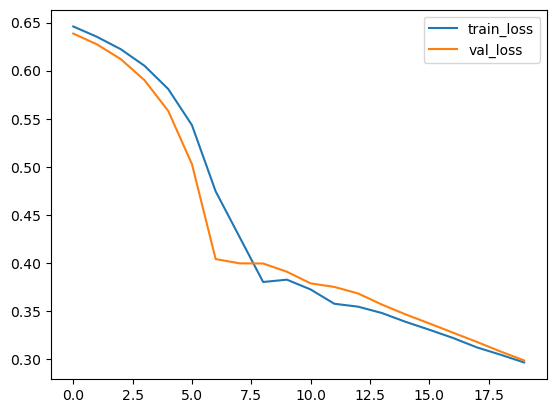

In [ ]:
#training and validation loop

import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt

import time
start = time.time()


model = Unet()

device = torch.device("cpu")
model = model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 20

train_loss_list = []
val_loss_list = []

#training loop
for epoch in range(num_epochs):

    #training
    train_loss = 0.0
    model.train()

    for images, masks in train_loader:

        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        #balance the loss per batch size
        train_loss += loss.item() * images.size(0)
    
    train_loss /= len(train_loader.dataset)

    train_loss_list.append(train_loss)

    #validation
    val_loss = 0.0
    model.eval()
    
    with torch.no_grad():

        for images, masks in val_loader:

            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            
            #balance the loss per batch size
            val_loss += loss.item() * images.size(0)
        
    val_loss /= len(val_loader.dataset)

    val_loss_list.append(val_loss)



    print(f"Epoch [{epoch+1}/{num_epochs}]  Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")


end = time.time()
print(f"Runtime {end - start}")

plt.figure()
plt.plot(train_loss_list, label='training loss')
plt.plot(val_loss_list,label='validation loss')
plt.legend()
plt.show
plt.savefig("Images/loss.png")



In [15]:
#testing loop

def dice_coeff(outputs, masks, smooth=1e-6):

    outputs = outputs.view(-1)
    masks = masks.view(-1)

    intersection = (outputs * masks).sum()
    dice = (2. * intersection + smooth) / (outputs.sum() + masks.sum() + smooth)

    return dice.item()


test_dice = 0.0
test_loss = 0.0
model.eval()

with torch.no_grad():

    for images, masks in test_loader:

        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        dice = dice_coeff(outputs, masks)
        loss = criterion(outputs, masks)
        
        #balance the loss per batch size
        test_dice += dice * images.size(0)
        test_loss += loss.item() * images.size(0)
    
test_dice /= len(test_loader.dataset)    
test_loss /= len(test_loader.dataset)

print(f"Mean dice coefficient on test set: {test_dice:.4f}")
print(f"Mean loss on test set: {test_loss:.4f}")

Mean dice coefficient on test set: 0.0862
Mean loss on test set: 0.2613


Saved visualization to single_prediction.png


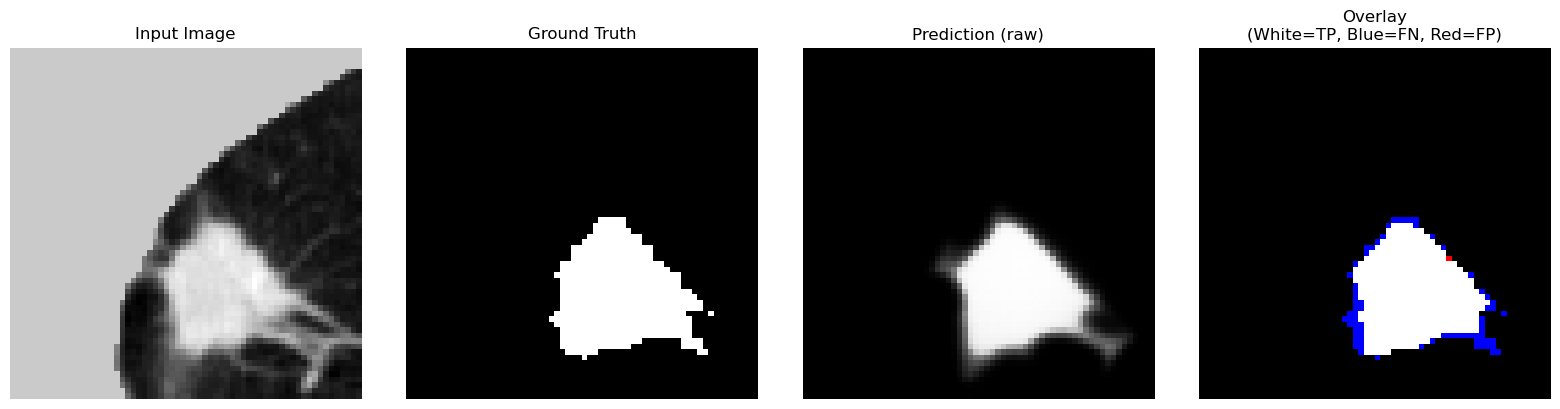

In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_prediction(image, mask, prediction, threshold=0.5, save_path=None):
    """
    Visualize segmentation prediction with color-coded overlay.
    
    Args:
        image: Input image tensor (1, H, W) or (H, W)
        mask: Ground truth mask tensor (1, H, W) or (H, W)
        prediction: Model prediction tensor (1, H, W) or (H, W), values 0-1
        threshold: Threshold for binarizing predictions (default 0.5)
        save_path: Path to save the figure (optional)
    
    Color coding:
        - White: Intersection (True Positives)
        - Blue: Mask only (False Negatives)
        - Red: Prediction only (False Positives)
        - Black: Background (True Negatives)
    """
    # Convert to numpy and remove channel dimension if present
    if isinstance(image, torch.Tensor):
        image = image.cpu().squeeze().numpy()
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().squeeze().numpy()
    if isinstance(prediction, torch.Tensor):
        prediction = prediction.cpu().squeeze().numpy()
    
    # Binarize prediction
    pred_binary = (prediction > threshold).astype(np.float32)
    mask_binary = mask.astype(np.float32)
    
    # Calculate intersection and differences
    intersection = (pred_binary * mask_binary)  # Both 1 (True Positive)
    mask_only = mask_binary - intersection      # Mask=1, Pred=0 (False Negative)
    pred_only = pred_binary - intersection      # Pred=1, Mask=0 (False Positive)
    
    # Create RGB overlay
    overlay = np.zeros((*image.shape, 3))
    
    # White for intersection (TP)
    overlay[intersection == 1] = [1, 1, 1]
    
    # Blue for mask only (FN)
    overlay[mask_only == 1] = [0, 0, 1]
    
    # Red for prediction only (FP)
    overlay[pred_only == 1] = [1, 0, 0]
    
    # Create figure with 4 subplots
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    # Original image
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')
    
    # Ground truth mask
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')
    
    # Prediction
    axes[2].imshow(prediction, cmap='gray', vmin=0, vmax=1)
    axes[2].set_title(f'Prediction (raw)')
    axes[2].axis('off')
    
    # Color-coded overlay
    axes[3].imshow(overlay)
    axes[3].set_title('Overlay\n(White=TP, Blue=FN, Red=FP)')
    axes[3].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved visualization to {save_path}")
    
    plt.show()


def save_multiple_predictions(model, test_loader, device, num_samples=5, 
                              threshold=0.5, save_dir='predictions'):
    """
    Save multiple prediction visualizations.
    
    Args:
        model: Trained model
        test_loader: Test data loader
        device: Device (cuda/cpu)
        num_samples: Number of samples to visualize
        threshold: Threshold for binarizing predictions
        save_dir: Directory to save images
    """
    import os
    os.makedirs(save_dir, exist_ok=True)
    
    model.eval()
    count = 0
    
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            
            # Visualize samples from this batch
            batch_size = images.size(0)
            for i in range(min(batch_size, num_samples - count)):
                save_path = os.path.join(save_dir, f'prediction_{count+1}.png')
                visualize_prediction(
                    images[i],
                    masks[i],
                    outputs[i],
                    threshold=threshold,
                    save_path=save_path
                )
                count += 1
                
                if count >= num_samples:
                    return
    
    print(f"Saved {count} visualizations to {save_dir}/")


'''# Example usage:
# After testing loop
if __name__ == "__main__":
    # Save 5 example predictions
    save_multiple_predictions(
        model=model,
        test_loader=test_loader,
        device=device,
        num_samples=5,
        threshold=0.5,
        save_dir='test_predictions'
    )'''
    
# Or visualize just one example
model.eval()
with torch.no_grad():
    images, masks = next(iter(test_loader))
    images, masks = images.to(device), masks.to(device)
    outputs = model(images)
    
    # Visualize first image in batch
    visualize_prediction(
        images[0],
        masks[0],
        outputs[0],
        threshold=0.5,
        save_path='single_prediction.png'
    )
